# Real Data — Matminer Feature Expansion + EDA + RF CV Comparison

**Goal**:
1) Expand composition-based features using **matminer** (Magpie)
2) **Split** (train/test) and perform **EDA on train**
3) Compare **RandomForestRegressor** with 5-fold CV:
   - RF on **original numeric features**
   - RF on **original + Magpie features**


In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = False
print('Imports OK')


Imports OK


## 1) Load dataset and prepare `formula`

In [6]:
csv_path = Path('..') / 'data' / 'DS1.csv'
assert csv_path.exists(), f"Could not find {csv_path}. Adjust the path if you moved the file."

# Load data
df0 = pd.read_csv(csv_path)

## 2) Feature expansion with matminer (composition + Magpie)

In [9]:
df = df0.copy()
df = StrToComposition().featurize_dataframe(df, 'Name')
ep = ElementProperty.from_preset(preset_name='magpie',impute_nan=True)
df = ep.featurize_dataframe(df, col_id='composition')
print('After Magpie expansion:', df.shape)
df.head(2)


StrToComposition:   0%|          | 0/2557 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/2557 [00:00<?, ?it/s]

After Magpie expansion: (2557, 220)


,Name,TC,Ag,Al,Am,As,Au,B,Ba,Be,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Co1Lu3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.546224,0.388803,0.579834,0.002247,194.0,194.0,0.0,194.0,0.0,194.0
1,Co3Lu4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.546224,0.664915,0.757334,0.002247,194.0,194.0,0.0,194.0,0.0,194.0


## 3) Train/Test split (use train for EDA and CV comparison)

In [10]:
y_all = df['TC']
X_mag_all = df.drop(columns=['TC']).select_dtypes(include=[np.number])
X_orig_all = df0.drop(columns=['TC']).select_dtypes(include=[np.number])
mask = y_all.notna()
y_all = y_all.loc[mask]
X_mag_all = X_mag_all.loc[mask]
X_orig_all = X_orig_all.loc[mask]
X_orig_train, X_orig_test, y_train, y_test = train_test_split(
    X_orig_all, y_all, test_size=0.30, random_state=123, shuffle=True
)
X_mag_train = X_mag_all.loc[X_orig_train.index]
X_mag_test  = X_mag_all.loc[X_orig_test.index]
X_orig_train.shape, X_mag_train.shape


((1789, 85), (1789, 217))

## 4) EDA on train
### 4A) Target `TC` — describe() + histogram

,TC_train
count,1789.000000
mean,293.519086
std,281.040460
min,0.000000
25%,39.000000
50%,213.000000
75%,510.000000
max,1387.600000


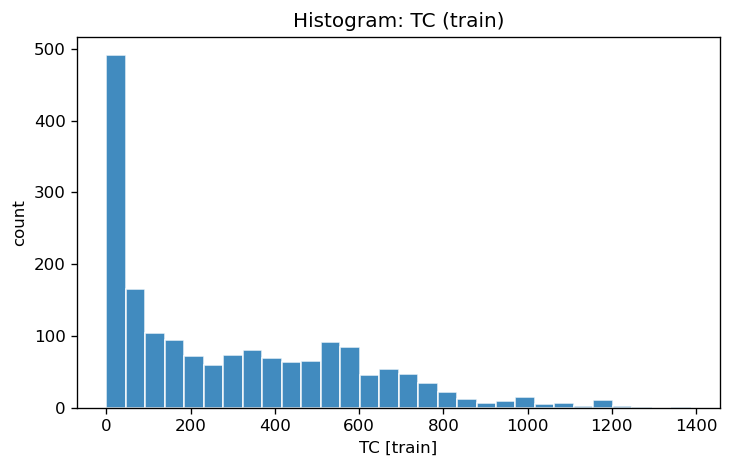

In [11]:
display(pd.DataFrame({'TC_train': y_train}).describe())
plt.figure(figsize=(6.2, 4.0))
plt.hist(y_train, bins=30, color='tab:blue', alpha=0.85, edgecolor='white')
plt.xlabel('TC [train]'); plt.ylabel('count')
plt.title('Histogram: TC (train)')
plt.tight_layout(); plt.show()


### 4B) Top correlated Magpie features with TC (train)

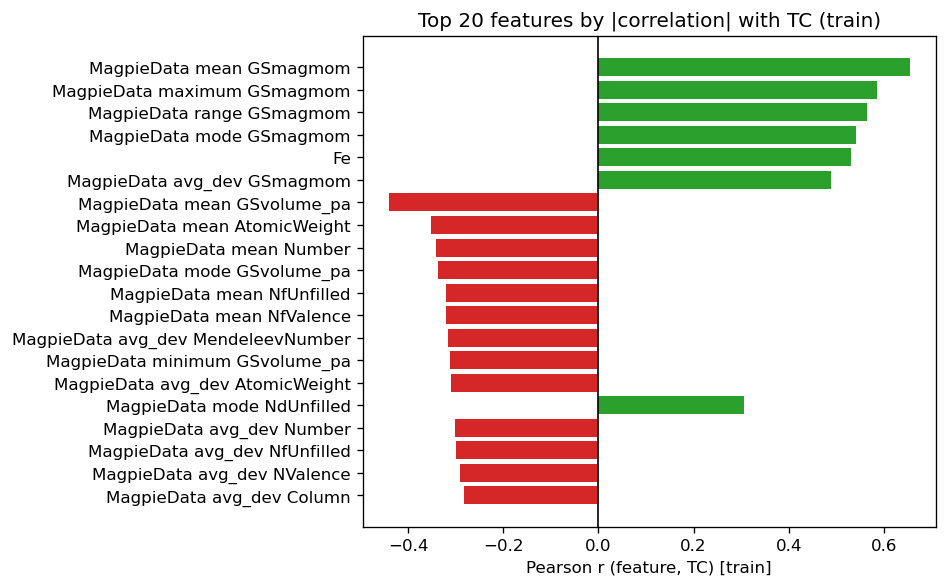

In [12]:
const_mask = X_mag_train.nunique(dropna=False) > 1
Xc = X_mag_train.loc[:, const_mask]
corr_series = Xc.corrwith(y_train)
corr_abs = corr_series.abs().sort_values(ascending=False)
topk = 20
top_feats = corr_abs.head(topk).index.tolist()
top_corr = corr_series.loc[top_feats].sort_values(key=lambda s: s.abs(), ascending=True)
plt.figure(figsize=(8.0, 5.0))
colors = ['tab:red' if v<0 else 'tab:green' for v in top_corr.values]
plt.barh(top_corr.index, top_corr.values, color=colors)
plt.axvline(0, color='k', lw=1)
plt.xlabel('Pearson r (feature, TC) [train]')
plt.title(f'Top {topk} features by |correlation| with TC (train)')
plt.tight_layout(); plt.show()


## 5) 5-fold CV comparison — RF on original vs. Magpie (train)

In [19]:
rf_orig = RandomForestRegressor(n_estimators=300, random_state=123, n_jobs=-1)
rf_mag = RandomForestRegressor(n_estimators=300, random_state=123, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=123)
scores_orig = cross_val_score(rf_orig, X_orig_train, y_train, scoring='r2', cv=cv)
scores_mag  = cross_val_score(rf_mag,  X_mag_train,  y_train, scoring='r2', cv=cv)
print('R^2 (orig) folds:', np.round(scores_orig, 4))
print('R^2 (mag ) folds:', np.round(scores_mag,  4))
print('Mean±Std R^2 (orig): {:.4f} ± {:.4f}'.format(scores_orig.mean(), scores_orig.std()))
print('Mean±Std R^2 (mag ): {:.4f} ± {:.4f}'.format(scores_mag.mean(),  scores_mag.std()))

R^2 (orig) folds: [0.7225 0.8465 0.7829 0.8602 0.8132]
R^2 (mag ) folds: [0.7966 0.8554 0.8229 0.8689 0.8415]
Mean±Std R^2 (orig): 0.8050 ± 0.0492
Mean±Std R^2 (mag ): 0.8371 ± 0.0254


### Plot: Mean CV R^2 with error bars

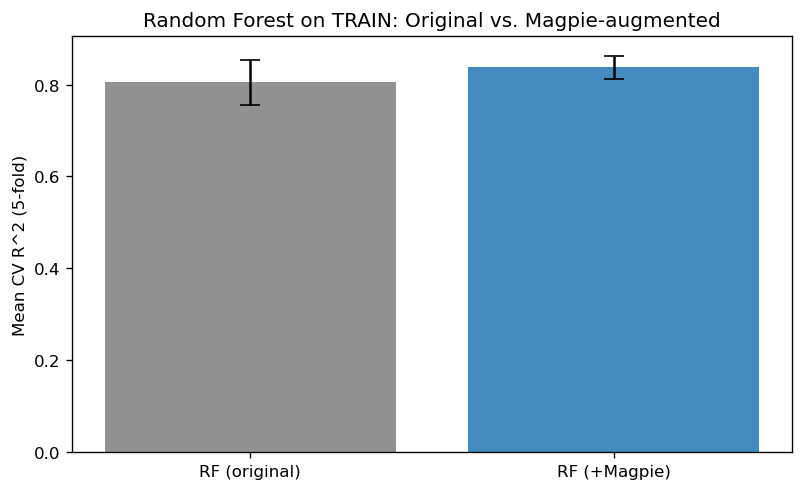

In [20]:
means = [scores_orig.mean(), scores_mag.mean()]
stds  = [scores_orig.std(),  scores_mag.std()]
labels = ['RF (original)', 'RF (+Magpie)']
plt.figure(figsize=(6.8, 4.2))
x = np.arange(2)
plt.bar(x, means, yerr=stds, capsize=6, color=['tab:gray','tab:blue'], alpha=0.85)
plt.xticks(x, labels)
plt.ylabel('Mean CV R^2 (5-fold)')
plt.title('Random Forest on TRAIN: Original vs. Magpie-augmented')
plt.ylim(bottom=min(0, min(means)-max(stds)))
plt.tight_layout(); plt.show()


## 6) Optional: Fit on train and evaluate on test (both variants)

In [23]:
rf_orig.fit(X_orig_train, y_train)
rf_mag.fit(X_mag_train, y_train)
y_pred_orig = rf_orig.predict(X_orig_test)
y_pred_mag  = rf_mag.predict(X_mag_test)
def report(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{label} - R^2: {r2:.4f}, MAE: {mae:.3f}')

report(y_test, y_pred_orig, 'TEST RF (original)')
report(y_test, y_pred_mag,  'TEST RF (+Magpie)')


TEST RF (original)  - R^2: 0.8032, MAE: 72.823
TEST RF (+Magpie)  - R^2: 0.8533, MAE: 67.982


## 7) Optional: Create a feature imptortance
The RandomforestRegressor provides a feature importance which reflects how much each feature reduces impurity across trees.

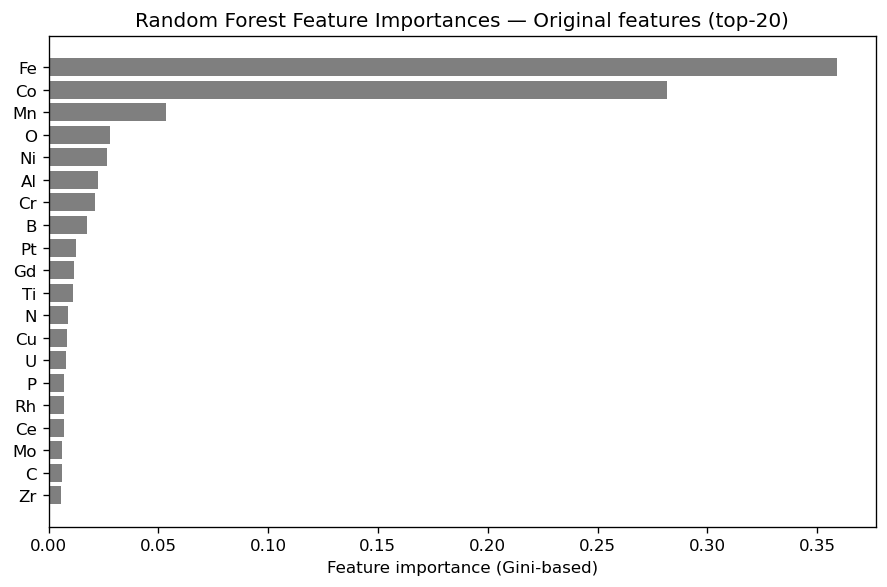

,feature,importance
26,Fe,0.358869
18,Co,0.281559
42,Mn,0.053623
50,O,0.028120
48,Ni,0.026416
1,Al,0.022418
19,Cr,0.021147
5,B,0.017596
57,Pt,0.012591
28,Gd,0.011793


In [26]:
# Column names that went into the pipeline (imputer doesn't change names)
feat_names_orig = X_orig_train.columns

# Importance values
imp_orig = rf_orig.feature_importances_

# Build a table and plot top-20
fi_orig = (pd.DataFrame({'feature': feat_names_orig, 'importance': imp_orig})
             .sort_values('importance', ascending=False)
             .head(20))

plt.figure(figsize=(7.5, 5.0))
plt.barh(fi_orig['feature'][::-1], fi_orig['importance'][::-1], color='tab:gray')
plt.xlabel('Feature importance (Gini-based)')
plt.title('Random Forest Feature Importances — Original features (top-20)')
plt.tight_layout(); plt.show()

fi_orig.head(20)
